## Dependencies to run this notebook
- pandas - Read and manipulate tabular data
- scipy - To run Hypothesis testing
- matplotlib - Used for visualization
- seaborn - Used for visualization
- sklearn (0.23.1) - Build ML models, hyper parameter tuning etc.
- imbalanced-learn(0.7.0) - Build ML models for imbalanced data
- shap - Explain ability of model
- scikit-plot - To generate cumulative Gain and Lift charts

In [33]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score,recall_score, f1_score,confusion_matrix,ConfusionMatrixDisplay,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.impute import KNNImputer

from imblearn.ensemble import BalancedRandomForestClassifier

import imblearn
import shap
import scikitplot as skplt

# Part 1 - Hypothesis Testing

## Goal - Determine if responders and non-responders tend to have the same age

In [23]:
# Load Data to pandas data frame
customer_data = pd.read_csv('DataScience_exercise_data.csv')
customer_data = customer_data.drop('id', axis=1)

### Descriptive statistics - Responders and Non-Responders age

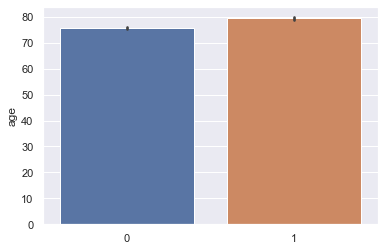

*************** Descriptive Statistics - Age of Responders *************** 
mean:  79.336
median:  79.0
std:  7.569835295857263
95% CI:  (78.86625625035654, 79.80574374964345)
N:  1000
*************** Descriptive Statistics - Age of Non-Responders ************
mean:  75.67266666666667
median:  74.0
std:  8.003845330146746
95% CI:  (75.38614236544628, 75.95919096788707)
N:  3000


In [9]:
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("darkgrid")
sns.set(font_scale = 1)
ax = sns.barplot(data=customer_data,x='target',y='age')
ax.set(xlabel='')
plt.show()

def calculate_descriptive_statistics(customer) :
    print("mean: ",np.mean(customer['age']))
    print("median: ",np.median(customer['age']))
    print("std: ",st.tstd(customer['age']))
    print("95% CI: ", st.t.interval(alpha=0.95, df=len(customer['age'])-1, 
                                    loc=np.mean(customer['age']), 
                                    scale=st.sem(customer['age'])))
    print("N: ",len(customer['age']))
print("*************** Descriptive Statistics - Age of Responders *************** ")    
calculate_descriptive_statistics(customer_data[customer_data['target'] == 1])
print("*************** Descriptive Statistics - Age of Non-Responders ************")  
calculate_descriptive_statistics(customer_data[customer_data['target'] == 0])

### By looking at the mean age of two groups, it appears mean age of responder group(79.33 ±7.56) is higher than non-responder group (75.67 ±8.00). 
### To find out whether this observed difference is statistically significant, perform a hypothesis test to determine mean age of responder group is higher than non-responder group

#### Null Hypothesis(H0) - Mean age of both responders and non-responders groups are same
#### Alternative Hypothesis(H1) - Mean age of responder group is higher than non-responder group

#### Experimentation setup - 
- <font><b>A right tailed(one side) independent T-test is used to access the difference between these two groups</b></font>
- <font><b> Lets use significance level α = 0.05 </b></font>
- <font><b> Used Scipy statistical package provided by python to conduct t-test</b></font>

### Outcome - Mean age of responder group(79.33 ±7.56) is higher than non-responder group (75.67 ±8.00) and its statistically significant (p<0.001)
- <font><b>P-value of <0.001 indicates that we can reject the null hypothesis(mean age of both responders and non-responders groups are same) and accept the alternative hypothesis(mean age of responder group is higher than non-responder group)</b></font>

In [5]:
responded_customer_age = customer_data[customer_data['target'] == 1]['age']
non_responder_customer_age = customer_data[customer_data['target'] == 0]['age']
val,p = ttest_ind(responded_customer_age,non_responder_customer_age)
print('Value:', val , ' p-value:',p/2)

Value: 12.703112333242013  p-value: 1.4150288244346763e-36


# Part 2 - Build a Binary Classifier to help this client better predict responders in future campaigns

## Exploratory analysis & data pre-processing 

### Target variable has imbalanced class distribution. Positive class (Responders - 1) is much less than negative class (Non-Responders - 0).

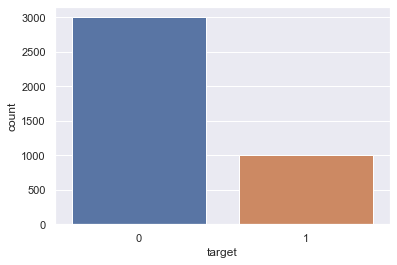

In [38]:
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("darkgrid")
sns.set(font_scale = 1)
sns.countplot(data=customer_data,x='target')
plt.show()

### This campaign is targeted more towards older demographics (65+ years)
### Dist is right-skewed/positively skewed

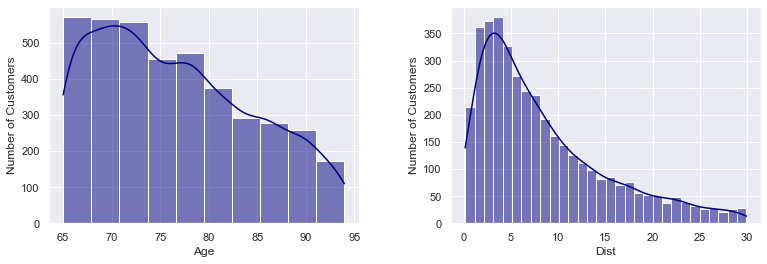

In [39]:
sns.set(rc={'figure.figsize':(12,5)})
fig, ax =plt.subplots(1,2)
fig.tight_layout(pad=5.0)
sns.set_style("darkgrid")
sns.set(font_scale = 1)
sns.histplot(data=customer_data,x='age',bins = 10,kde = True,color='navy',ax=ax[0])
sns.histplot(data=customer_data,x='dist',bins = 30,kde = True,color='navy',ax=ax[1])
ax[0].set(xlabel='Age',ylabel='Number of Customers')
ax[1].set(xlabel='Dist',ylabel='Number of Customers')
plt.show()

### Almost equal proportion of male and female
### There is a high imbalance in marital status. Around 60% of customers are married.

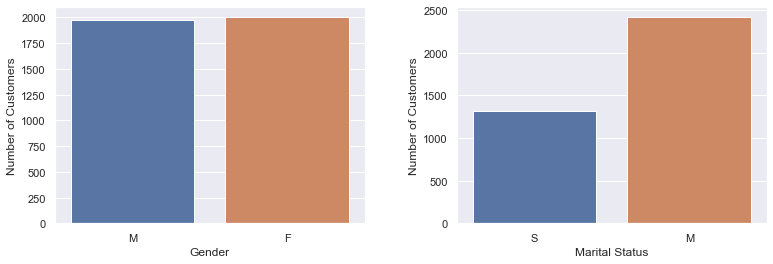

In [9]:
sns.set(rc={'figure.figsize':(12,5)})
fig, ax =plt.subplots(1,2)
fig.tight_layout(pad=5.0)
sns.set_style("darkgrid")
sns.set(font_scale = 1)
sns.countplot(data=customer_data,x='gender',ax=ax[0])
sns.countplot(data=customer_data,x='marital_status',ax=ax[1])
ax[0].set(xlabel='Gender',ylabel='Number of Customers')
ax[1].set(xlabel='Marital Status',ylabel='Number of Customers')
plt.show()

### Distribution of income

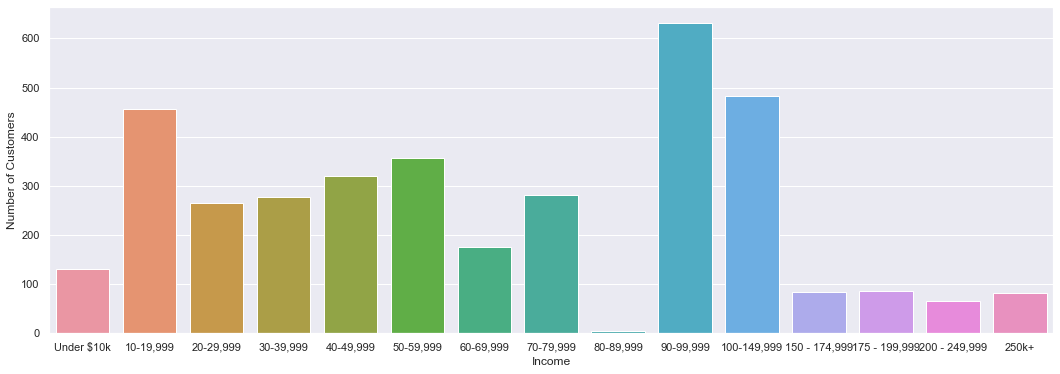

In [8]:
sns.set(rc={'figure.figsize':(18,6)})
sns.set_style("darkgrid")
sns.set(font_scale = 1)
order = ['Under $10k','10-19,999','20-29,999','30-39,999','40-49,999','50-59,999','60-69,999',
         '70-79,999','80-89,999','90-99,999','100-149,999','150 - 174,999','175 - 199,999',
         '200 - 249,999','250k+']
ax=sns.countplot(data=customer_data,x='income',order=order)
ax.set(xlabel='Income',ylabel='Number of Customers')
plt.show()

### Convert categorical features to numerical 

In [24]:
customer_data['income']=customer_data['income'].map(
    {'Under $10k':1,'10-19,999':2,'20-29,999':3,'30-39,999':4,'40-49,999':5,
     '50-59,999':6,'60-69,999':7,'70-79,999':8,'80-89,999':9,'90-99,999':10,
      '100-149,999':11,'150 - 174,999':12,'175 - 199,999':13,'200 - 249,999':14,'250k+':15})
customer_data['gender']=customer_data['gender'].map({'M':1,'F':0})
customer_data['marital_status']=customer_data['marital_status'].map({'M':1,'S':0})

### Understand the co-relation between variables (using spearman correlation. Value >0.5 or <-0.5 is considered moderate to strong relation )
- <font><b>Age and target variable are positively correlated. As age increases, chances of responding to campaign also increases.</b></font>
- <font><b>Age and income are negatively correlated. As age increases, income decreases.</b></font>
- <font><b>Married people have more income.</b></font>
- <font><b>Men has more income compared to Women.</b></font>
- <font><b>Income and target variables are negatively correlated. Lower income people tend to respond more to campaign.</b></font>

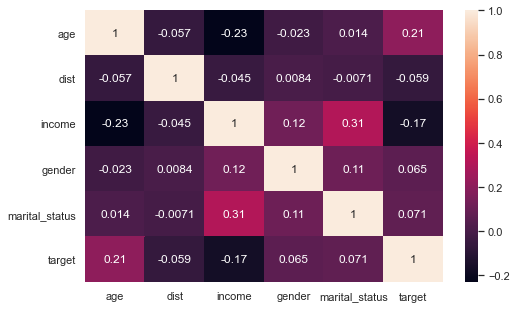

In [24]:
corrMatrix = customer_data.corr(method ='spearman')
sns.set(rc={'figure.figsize':(8,5)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Build Predective Model

### Choose performance metrics for the predictive model
- <font><b>We want to maximize the number of customers the model correctly predicts who would respond to the campaign.</b></font>
- <font><b>In this case, Recall is more important than Precision (assuming the cost of acting is low) , but the opportunity cost of passing up on a customer is high.</b></font>
- <font><b>Note: If the cost of acting is too high or budget is a concern, then we need to consider a more conservative  approach of balancing precession and recall.</b></font>

### Prepare data and split into Train(80%) & Test(20%) 

In [25]:
Y_feature = customer_data['target']
customer_data.drop('target', axis=1,inplace=True)
x_train, x_test, y_train, y_test = train_test_split(
    customer_data, 
    Y_feature, 
    test_size=0.20,
    random_state=5)

### Handling missing data
- <font><b>Income, Gender, Marital status data is missing for few hundred records</b></font>
- <font><b> I tried imputing missing data with simple imputations methods like mean, median and mode. But the final model used more sophisticated techniques like imputation using K-nearest neighbor due to the better model performance</b></font>

In [26]:
print("Missing Values:")
print(customer_data.isnull().sum())

Missing Values:
age                 0
dist                0
income            297
gender             24
marital_status    258
dtype: int64


In [27]:
# Apply KNN Imputer on Training data, build model and transform x-train and x-test
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(x_train)
x_train = imputer.transform(x_train)
x_test = imputer.transform(x_test)

### Build a reference baseline model
- <font><b>RandomForestClassifier is built with all default parameters.</b></font>
- <font><b>Data is highly imbalanced.</b></font>
- <font><b>As you can see, the model is performing very poorly for all performance metrics (recall, precession) </b></font>

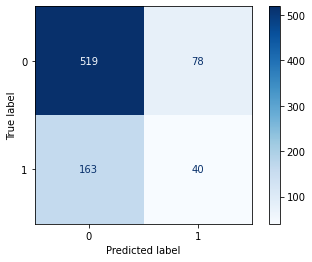

F1 score: 0.24922118380062305
Recall: 0.19704433497536947
Precision: 0.3389830508474576
roc_auc_score: 0.5331955343218555


In [21]:
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)

disp.plot(cmap='Blues', ax=None, xticks_rotation='horizontal')
plt.show()

print('F1 score:', f1_score(y_test, predictions))
print('Recall:', recall_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('roc_auc_score:', roc_auc_score(y_test, predictions))

### First version of Improved model
- <font><b>Used BalancedRandomForestClassifier model from package imblearn.</b></font>
- <font><b>A balanced random forest randomly under-samples(majority class) for each bootstrap sample to balance it. Since we are under sampling majority class for each bootstrap (hundreds of trees), it does not lead to information loss</b></font>
- <font><b>This model is optimized for high recall.</b></font>

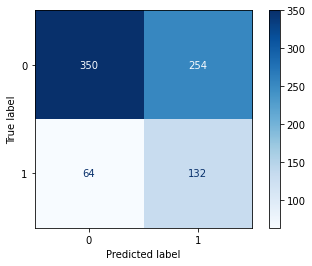

F1 score: 0.4536082474226804
Recall: 0.673469387755102
Precision: 0.34196891191709844
roc_auc_score: 0.6264697932152994


In [38]:
clf = BalancedRandomForestClassifier()
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)

disp.plot(cmap='Blues', ax=None, xticks_rotation='horizontal')
plt.show()
print('F1 score:', f1_score(y_test, predictions))
print('Recall:', recall_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('roc_auc_score:', roc_auc_score(y_test, predictions))

### Find optimal hyper parameters using grid search 

In [39]:
param_grid_values = {'n_estimators': [i for i in range(10,100,10)], 
                     'max_depth': [i for i in range(2,10,2)],
                     'criterion': ['gini','entropy'],
                     'max_features' : ['auto','sqrt','log2']
                     }
# Optimized for high recall
grid_search_rf = GridSearchCV(estimator = clf,
                              param_grid = param_grid_values, 
                              scoring='recall',cv=2,n_jobs=2)
grid_search_rf.fit(x_train,y_train)
grid_search_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 'log2',
 'n_estimators': 30}

### Build final model using the optimal hyper parameters

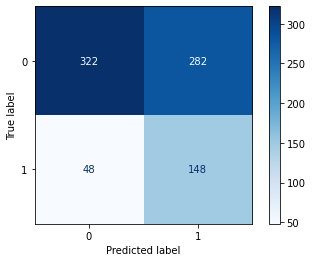

F1 score: 0.4728434504792332
Recall: 0.7551020408163265
Precision: 0.34418604651162793
roc_auc_score: 0.6441073117988916


In [40]:
clf_final = BalancedRandomForestClassifier(n_estimators=30,max_features='log2',max_depth=2,criterion='entropy')
clf_final.fit(x_train, y_train)
predictions = clf_final.predict(x_test)
cm = confusion_matrix(y_test, predictions, labels=clf_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_final.classes_)

disp.plot(cmap='Blues', ax=None, xticks_rotation='horizontal')
plt.show()
print('F1 score:', f1_score(y_test, predictions))
print('Recall:', recall_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('roc_auc_score:', roc_auc_score(y_test, predictions))

# Part 3 - Cumulative gains and lift curves for measuring the effectiveness of  predictive model

### Cumulative Gains Curve
- <font><b>From the cumulative gain graph below, our model is doing much better job in selecting customers who respond to campaign compared to random selection instead</b></font>
- <font><b>Ex. If we select the top 20% cases based on our model, we will select 40% of the target class.</b></font>

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

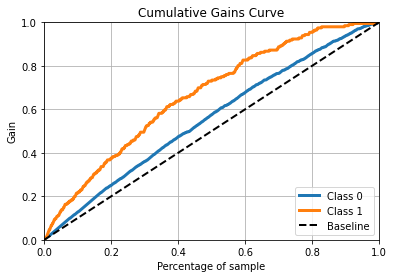

In [41]:
predicted_probabilities = clf_final.predict_proba(x_test)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probabilities)

### Cumulative Lift Curve

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

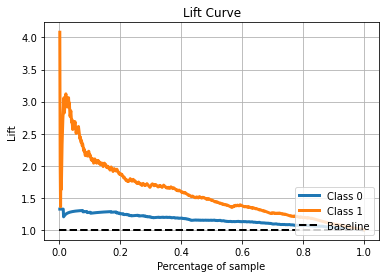

In [42]:
skplt.metrics.plot_lift_curve(y_test, predicted_probabilities)

# Insights from the Model
- <font><b>SHAP is a mathematical method to explain the predictions of machine learning models. It is based on the concepts of game theory and can be used to explain the predictions of any machine learning model by calculating the contribution of each feature to the prediction.</b></font>

In [53]:
x_train_sample = shap.sample(x_train, 200)
explainer = shap.KernelExplainer(clf_final.predict,x_train_sample)
shap_values = explainer.shap_values(x_train_sample)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


### Insights from the model
- <font><b>Older people are more likely to respond to campaign.</b></font>
- <font><b>Lower income people are more likely to respond to campaign.</b></font>
- <font><b>Males are more likely to respond to campaign compared to Female.</b></font>
- <font><b>Married people are more likely to respond to campaign compared to Single.</b></font>

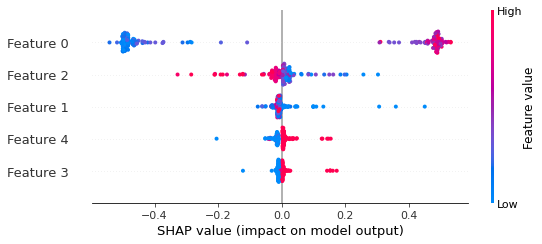

In [52]:
shap.summary_plot(shap_values, x_train_sample)
# Feature 0 - Age
# Feature 1 - Dist
# Feature 2 - Income
# Feature 3 - Gender (Female=0 , Male=1)
# Feature 4 - Maritial status (Single=0 , Married=1)

### Feature importance

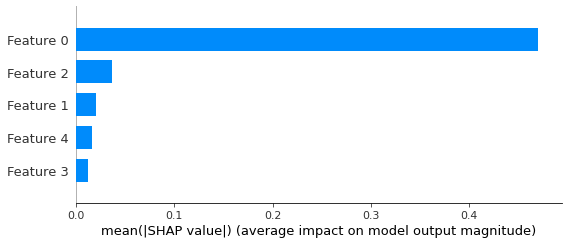

In [51]:
shap.summary_plot(shap_values, x_train_sample, plot_type="bar")

### If i had more time
- <font><b>Try with other models like RandomForest/XGBoost with oversampling/under sampling, SMOOTE etc.</b></font>
- <font><b>Organize the code better by building sklearn pipeline with k-fold cross-validation</b></font>

# Part 4 - Executive Summary

### Right tailed independent T-test is performed to compare the mean age of responders and non-responders group. Mean age of responders group(79.33 ±7.56) is higher compared to non-responder group (75.67 ±8.00) and its statistically significant (p<0.001)
### Predictive model is built to predict responders in future campaigns. The model is optimized to maximize the number of customers it correctly predicts who would respond to the campaign (for high recall)
### Random Forest classifier is used to build the model. Missing values are imputed(using K-Nearest neighbor approach) and the algorithm address the class imbalance by random under sampling of majority class for each bootstrap. This model has a recall rate of 0.75
### Our model is doing much better job in selecting customers who respond to campaign compared to random selection instead. Ex. If we select the top 20% cases based on our model, we will select 40% of the target class.
### Age and Income are the two most influenced features used by the model. One of the main insights from the model is that older and lower income people are more likely to respond to campaign.